In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


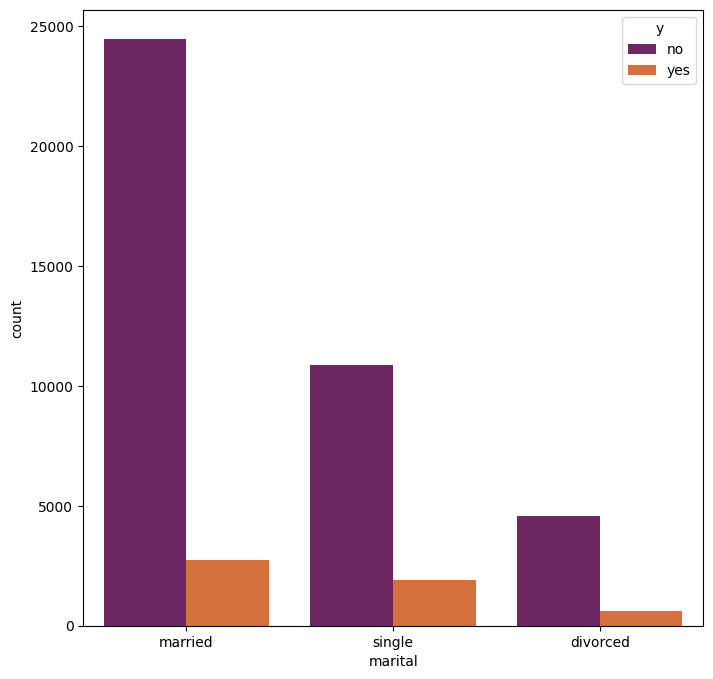

In [4]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'marital', hue = 'y', data = df, palette = 'inferno')
plt.show()

#### Bekar insanlarin evli insanlara göre vadelı para tutma oranının çok daha fazla olduğunu görüyoruz.

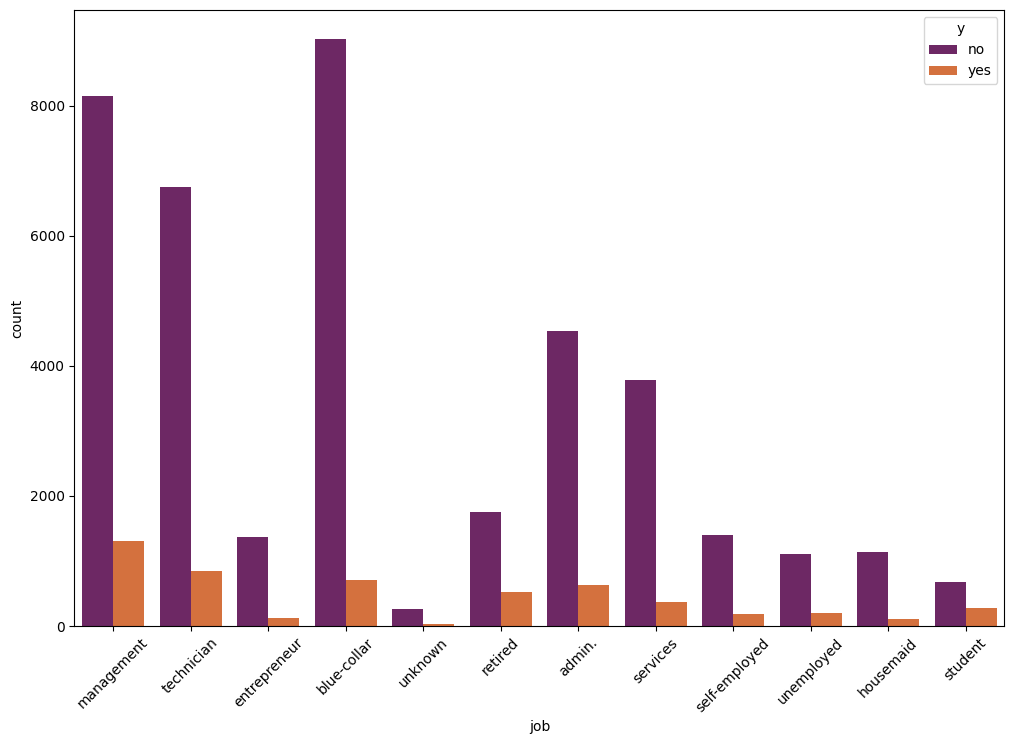

In [5]:
plt.figure(figsize=(12,8))
sns.countplot(x = 'job', hue = 'y', data = df, palette = 'inferno')
plt.xticks(rotation = 45)
plt.show()

Bu tabloda meslek dağılımlarına göre insanların bankaya vadeli para yatırıp yatırmadığını görebiliyoruz. Örneğin mavi yakalıların vadeli para yatırmayı en az tercih eden grup, yöneticilerin ise en çok tercih eden grup olduğunu görebiliyoruz. Tabi bunların oransal olarak karşılaştırılması yapıldığında daha doğru bir yorum elde edebiliriz.

Depozito yatirmakla diger degiskenler arasindaki korelasyonu incelemek istiyorum. Fakat oncesinde elimde bulunan kategorik degiskenleri, modelin anlamasi icin binary hale getirecegim.

In [6]:
columns = df.select_dtypes(include = 'object').columns

df = pd.concat([df, pd.get_dummies(df[columns])], axis=1)
df = df.drop (['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month','poutcome', 'y', 'y_no'],axis =1)

df.head(10)
print(len(df.columns))

52


Satır sayımız 52'ye çıktığı için 52x52 bir korelasyon matrisine bakmak zor olucaktırç Bu yüzden depozito yatırmakla en yüksek korelasyona sahip 10 değişkeni seçiyorum.

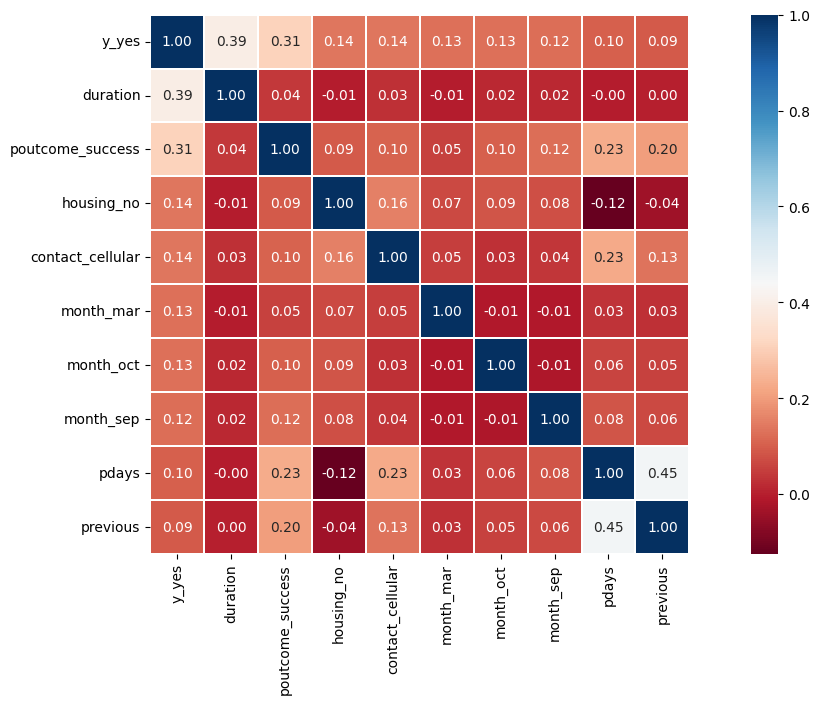

In [7]:

fig,axes = plt.subplots(figsize=(16, 7))
corr = df.corr()
max_corr = corr.nlargest(10, 'y_yes')['y_yes'].index
cm = np.corrcoef(df[max_corr].values.T)
matrix = sns.heatmap(cm, annot=True, square=True, fmt='.2f', 
                 linewidths= 0.1, vmax = 1, cmap = 'RdBu',
                  yticklabels=max_corr.values, xticklabels=max_corr.values, ax = axes)
plt.show()

Depozito yatirmakla en yuksek korelasyonu olan ozellikler:
* Son telefon konusmasinin uzunlugu
* Bir onceki pazarlama kampanyasinin sonucu
* ev kredisi alinmamasi
* Iletisimin cep telefonuyla gercekelsmis olmasi

Veri analizi kizmindan bir kasik aldiktan sonra asil konumuz olan hyper-parameter secimine gecebiliriz.

In [8]:
y = df.y_yes
df = df.drop(['y_yes'], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

elimizdeki veri setini train ve test setlerine ayirdiktan sonra random forest modelimi olusturuyorum.

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11966
           1       0.77      0.16      0.27      1598

    accuracy                           0.90     13564
   macro avg       0.83      0.58      0.60     13564
weighted avg       0.88      0.90      0.86     13564



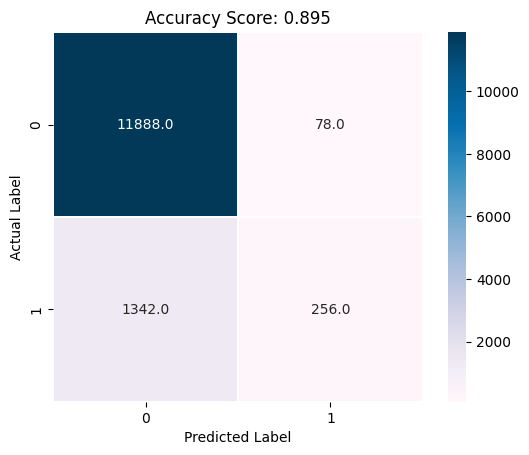

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm 
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, n_jobs =-1, random_state=0, max_features=10, max_depth=5)

rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print(classification_report(y_test, rf_predict))

score = round(accuracy_score(y_test, rf_predict), 3)
cm1 = cm(y_test, rf_predict)

sns.heatmap(cm1, annot=True, fmt = '.1f', linewidths=.3, square=True, cmap='PuBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Accuracy Score: {0}'.format(score))
plt.show()

In [12]:

from sklearn.model_selection import GridSearchCV, cross_val_score

print(cross_val_score(RandomForestClassifier(n_estimators=100, 
                                 n_jobs=-1, random_state=0, max_features= 10, 
                            max_depth= 5), 
                              X_train, y_train, cv=5))
print('')
print('mean of cv-scores: {0}'.format(round(np.mean(cross_val_score(RandomForestClassifier(n_estimators=100, 
                                 n_jobs=-1, random_state=42, max_features= 10, 
                            max_depth= 5), 
                              X_train, y_train, cv=5)),4)))

[0.89526066 0.8957346  0.89666614 0.89508611 0.89398009]

mean of cv-scores: 0.8956


In [13]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=0)

rf_params = {'max_depth': range(3,13), 'max_features': range(5,15)}

rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=True)

rf_grid.fit(X_train, y_train)
print('***************************************')
print(rf_grid.best_params_)
print('Best cv mean result: {0}'.format(round(rf_grid.best_score_), 5))
print('Best holdout result: {0}'.format(round(accuracy_score(y_test, rf_grid.predict(X_test)), 5)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
***************************************
{'max_depth': 12, 'max_features': 14}
Best cv mean result: 1
Best holdout result: 0.90467
